In [1]:
#imports such as Open CV library, NumPy Library, os module, Pandas etc.
import cv2
import pandas as pd
import numpy as np 
import os
import seaborn as sns
import glob
import matplotlib.pyplot as plt

#Import tensorflow library the most commonly used framework for machine learning models
import tensorflow as tf

#prints the version of TensorFlow Library Installed
print('Tensorflow version :' , tf.__version__)

#Imports keras module from the tensorflow library. Keras is a high-level neural network used for training machine learning models.
from tensorflow import keras

#prints the version of keras installed
print('keras version:' , keras.__version__)

#Imports element Tree used to read .xml files.
from xml.etree import ElementTree

#Assigns directory paths to both the annotation files and image files
image_Dir = './images'
annotations_Dir = './annotations'

Tensorflow version : 2.12.0
keras version: 2.12.0


In [2]:

#creates an empty list where .xml files will be stored.
annot_files = []

#appends annotation .xml files to the anno_files list in a for loop
for file in glob.glob(annotations_Dir + '\*.xml'):
    annot_files.append(os.path.abspath(file))



In [9]:
#Obtains the list of file names in the Images file and assigns them to the image directory 
image_files_list = os.listdir(image_Dir) 



In [10]:
#information will be used to extract information from the .xml annotation files files

information = {
    #includes the data collected from the .xml fies
    #minimum x value
    'xmin' : [],
    'ymax' : [],#maximum y value
    'label': [],#label (name of class)
    'xmax' : [],#maximum x value
    'ymin' : [],#minimum y value
    'w': [],#width
    'h': [],#height
    'imgfile' : [],#name of image file
    'annotfile':[],#annotation file name
    'depth' :[]#depth of image
}

for annot_file in (annot_files):
    #extracts information such as width, height, and depth of image
    xmlTree = ElementTree.parse(annot_file)
    for node in xmlTree.iter():
        if 'folder' in node.tag:
            imgfoldername = node.text
        elif 'filename' in node.tag:
            img_file_name = node.text
        if 'size' in node.tag:
            for child_node in list(node):
                if 'width' in child_node.tag:
                    w = int(round(float(child_node.text)))
                if 'height' in child_node.tag:
                    h = int(round(float(child_node.text)))   
                if 'depth' in child_node.tag:
                    depth = int(round(float(child_node.text)))
        #extracts information like label, xmin, ymin, ymax
        #stores all of the information into the information dictionary.
        if 'object' in node.tag:
            for obj_child_node in list(node):
                if 'name' in obj_child_node.tag:
                    name = obj_child_node.text
                    information['label']+=[name]
                    information['w']+=[w]
                    information['h'] += [h]
                    information['depth']+= [depth]
                    information['imgfile']+= ['./'+ imgfoldername + '/'+ img_file_name]
                    information['annotfile']+=[annot_file]
        #this code reads the xml files, and extracts information about the image file. 
        
                if 'bndbox' in obj_child_node.tag:
                    for bndbox_child in list(obj_child_node):
                        if 'xmin' in bndbox_child.tag:
                            xmin = int(round(float(bndbox_child.text)))
                            information['xmin']+=[xmin]
                        if 'ymin' in bndbox_child.tag:
                            ymin = int(round(float(bndbox_child.text)))
                            information['ymin']+=[ymin]
        #It stores the image dimensions, coordinations, and file path
        #the extracted information will be used for training the model and evaluation.
                        if 'xmax' in bndbox_child.tag:
                            xmax = int(round(float(bndbox_child.text)))
                            information['xmax']+=[xmax]
                        if 'ymax' in bndbox_child.tag:
                            ymax = int(round(float(bndbox_child.text)))
                            information['ymax']+=[ymax]


In [11]:
#this code converts the information dictionary created previously
#and converts it into a pandas DataFrame named 'information_df'
#Each key created becomes a column and the data is listed for each
#key
information_df = pd.DataFrame(information)


In [12]:
#Takes an image input and displays it using matplotlub

def render(image):
    plt.figure(figsize =(12,8) )
    #the specific size will be 12x8
#the function is then displayed on the screen.
    plt.imshow(image)
    plt.show()


def convert_RGB (image):
    #function converts BGR image to the RGB color space. This format
    #is used by most visualiztion tools
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

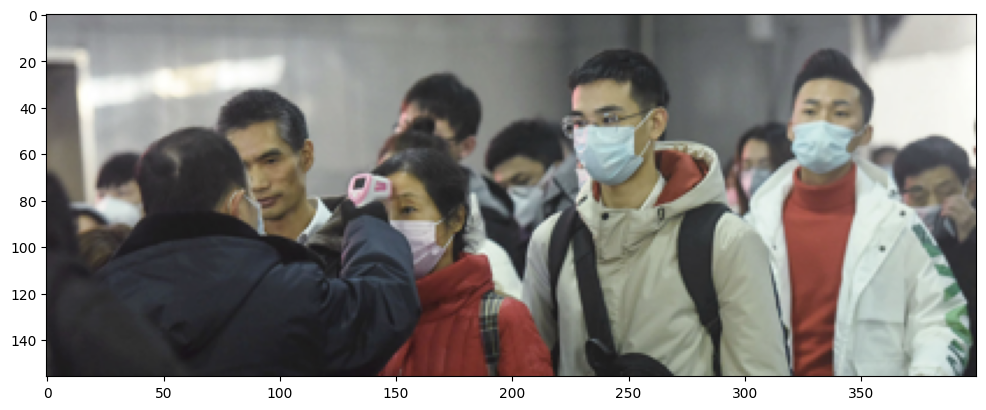

(156, 400, 3)

In [13]:
#tests out if the code is working so far.
img_index = 10
#assigns the index of the image that will be used in this example

#gets the value from the imgfile column in the information_df dataframe. This is the file path to the image
temp_img_file_name=information_df['imgfile'].iloc[img_index]

#this reads teh image location in the image stored in the temp_img_file name
img_tmp = cv2.imread(temp_img_file_name)

#conversts the image and displays the image using mathplot libe
render(convert_RGB(img_tmp))
 
#gets the shape of the image (h,w,number of color channels.)
img_tmp.shape




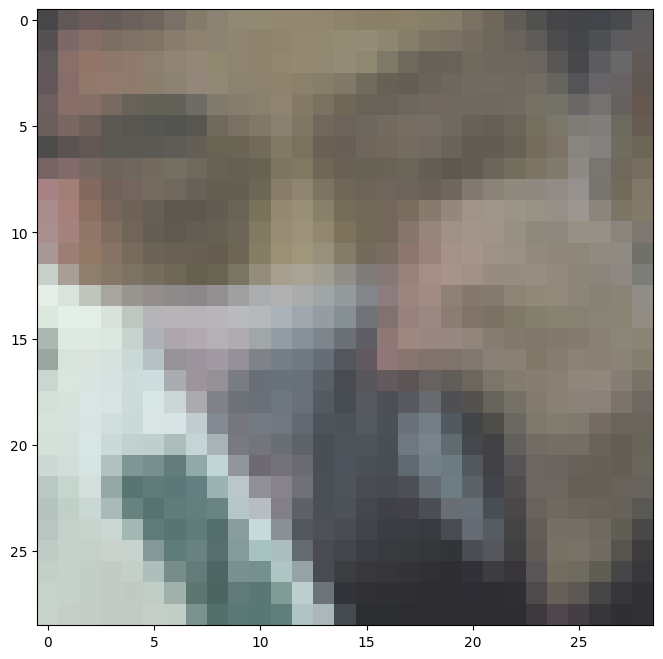

In [14]:

#crops the image using the values from the _df chart
#gets the xmin value 
x = information_df['xmin'].iloc[img_index]
#gets the ymin value
y = information_df['ymin'].iloc[img_index]
#gets the xmax value
width = information_df['xmax'].iloc[img_index]
#gets the y max value
height = information_df['ymax'].iloc[img_index]

#crops the image using the regions specificed by the coordinates collected.
crop_image_tmp = img_tmp[y:height, x:width]
#converts the image to the correct colorspace
render(convert_RGB(crop_image_tmp))

In [16]:


# Create a path for a directory named "working"
work_dir = os.path.abspath('./working')

# Check if the 'working' directory exists, and create it if it doesn't
if not os.path.exists(work_dir):
    os.mkdir(work_dir)

# Create a path for a directory inside the 'working' directory called 'cropped'
cropped_dir = os.path.join(work_dir, 'cropped')

# Check if the 'cropped' directory exists, and create it if it doesn't
if not os.path.exists(cropped_dir):
    os.mkdir(cropped_dir)


In [17]:
#creates a new column in the info_df dataframe that stores all of the cropped images
information_df['cropped_img'] = information_df['imgfile']





In [18]:
#loop that loops over reach row in the info_df data frame 
for index in range(len(information_df)):
#retrieves file names from the column at the index
    img_file_name = information_df['imgfile'].iloc[index]

#extracts the base filename and splits the file name removing it.
    no_extension_file_name = os.path.basename(img_file_name).split('.')[0] 
#creates file name for the cropped image combing the other paths.
    cropped_file_name=os.path.join(cropped_dir, no_extension_file_name + '-'+ str(index)+ '.png')
#includes this into the dataframe
    information_df['cropped_img'].iloc[index] = cropped_file_name

    img_tmp = cv2.imread(temp_img_file_name)

#retreives the coordinates of the min, max, min, max of the x and y coordinates
    x = information_df['xmin'].iloc[img_index]
    y = information_df['ymin'].iloc[img_index]
    #max, min, max of the x and y coordinates
    width = information_df['xmax'].iloc[img_index]
    height = information_df['ymax'].iloc[img_index]

#creates the cropped image using the specific coordinates provided 
    crop_image_tmp = img_tmp[y:height, x:width]
#saves the cropped image to the path
    cv2.imwrite(cropped_file_name, crop_image_tmp)



C:\Users\sriee\AppData\Local\Temp\ipykernel_10896\4262213225.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  information_df['cropped_img'].iloc[index] = cropped_file_name
C:\Users\sriee\AppData\Local\Temp\ipykernel_10896\4262213225.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  information_df['cropped_img'].iloc[index] = cropped_file_name
C:\Users\sriee\AppData\Local\Temp\ipykernel_10896\4262213225.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

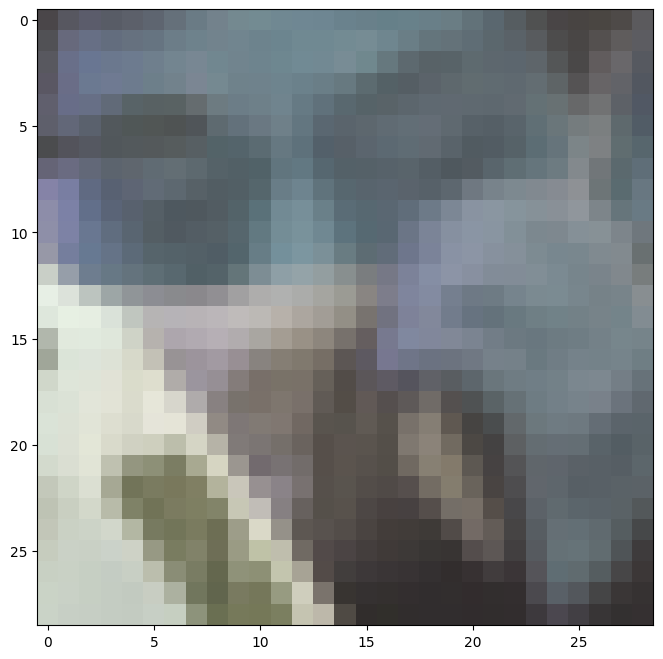

In [19]:
#renders a specific cropped image from the cropped directory 

render(cv2.imread(information_df['cropped_img'].iloc[img_index]))
#used to understand what the progress of the code is like so far

In [20]:
#Utilzies function from scikit-larn to split the dataset into training and testing dataset

#module used to split the datset
from sklearn.model_selection import train_test_split
#splits dat into 30% testing and 70% training data
#information_df has the data to be split
training_df, test_df = train_test_split(information_df , test_size = 0.3)



In [21]:
#creates a list named classes that will have the labels of the images in the training_df data
classes = list(training_df['label'].unique())
classes
#there are 3 classes

['without_mask', 'with_mask', 'mask_weared_incorrect']

In [22]:
#counts the occurence of each different class and how many images are in each class
training_df['label'].value_counts()

label
with_mask                2262
without_mask              503
mask_weared_incorrect      85
Name: count, dtype: int64

In [23]:
#Creates a table with the information of the amount of photos for each type
labels_table = pd.DataFrame(training_df['label'].value_counts()).reset_index()
#will have the label name and the count
labels_table.rename(columns={'index': 'label', 'label': 'count'}, inplace = False)
#prints the table
labels_table

,label,count
0,with_mask,2262
1,without_mask,503
2,mask_weared_incorrect,85


In [24]:

#arrays that store the width and height of the image
image_width= []
image_height=[]

for index in range(len(training_df)):
   
   #retrieves the cropped file name for the the row and column
   cropped_image = cv2.imread(cropped_file_name)
#appends the width and height of a specific image
   image_width.append(cropped_image.shape[0])
   image_height.append(cropped_image.shape[1])

   

In [25]:
#calculates the dimensions of the images using the median values of the width and height lists. 
image_expected = (int(np.median(image_width)), int(np.median(image_height)))
#this allows for the data to be standardized because they will be of the same size
#in the machine learning 
image_expected

(29, 29)

In [26]:
#returns the exptedted shape of the image used for the model
shape = [int(np.median(image_width)), int (np.median(image_height)),3]
#gathers the median size for w and h
shape

[29, 29, 3]

In [27]:
#Imports the imageDatagenerator from Keras allowing for PREPROCESSING
from keras.preprocessing.image import ImageDataGenerator
#rescales the pixel values to a range [0,1]
training_generator = ImageDataGenerator(rescale=1. / 255., validation_split=0.30)

train_generator = training_generator.flow_from_dataframe(
    #creates a generator to house the training data
    #holds labels
    dataframe=training_df,
    #where images are located
    directory='./',  
    x_col='cropped_img',  #column of the file path
    y_col='label', #column with the labels
    subset='training',#specifications for training
    batch_size=32,#batch size
    seed=42,#random seed
    shuffle=True,#shuffles the seed
    class_mode='categorical',#the labels are categorical
    target_size=image_expected#uses the target size indicated
)
#creates a generator for the validation data 
valid_generator = training_generator.flow_from_dataframe(
    dataframe=training_df,#holds labels
    directory='./',  #where images are located
    x_col='cropped_img',  #column of the file path
    y_col='label',  #column with the labels
    subset='validation',#specifications for training
    batch_size=32,#batch size
    seed=42,#random seed
    shuffle=True,#shuffles the seed
    class_mode='categorical',#the labels are categorical
    target_size=image_expected#uses the target size indicated
)


Found 1995 validated image filenames belonging to 3 classes.
Found 855 validated image filenames belonging to 3 classes.


In [28]:
#rescales the images to a range of [0,1]
test_images= ImageDataGenerator(rescale = 1./255.)
#creates a generator for the testing data.
test_generator= training_generator.flow_from_dataframe(
    
    dataframe=test_df,#datafram that holds the testing data
    directory='./',   #where images are located
    x_col='cropped_img',  #column of the file path
    y_col='label',#column with the labels
    batch_size=32,#batch size
    seed=42,#random seed
    shuffle=True,#shuffles the seed
    class_model= 'categorical',#the labels are categorical
    target_size=image_expected#uses the target size indicated
    
)

Found 1222 validated image filenames belonging to 3 classes.


In [29]:
########################################
#code that will be altered for each model
#this is an example model that has 3 hidden layers
#this investigation will alter the number of hidden layers


#uses a linear stack of layers 
#keras model

model = keras.models.Sequential([
    #input layer is implied
    keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=shape),#hidden layer 1 
    keras.layers.MaxPool2D(pool_size=2, padding='valid'),#not counted as a hidden layer
    keras.layers.Flatten(),#hidden layer 2
    keras.layers.Dense(units=len(classes), activation='softmax')#hidden layer 3
    #output layer is implied
])

########################################

In [30]:
#compules the model with the with the Adam optimizer
#calculates the loss
#accurary and 
model.compile(optimizer=keras.optimizers.Adam(),
               loss='categorical_crossentropy',
               
               metrics=['accuracy', keras.metrics.Recall()])
               #recal 

#imports the time module
import time

# Record the start time before the module begins
start_time = time.time()

# Train the models using the train_genertor and validates it runs for 10 epochs
history1 = model.fit(train_generator, epochs=10, steps_per_epoch=len(train_generator),
                      validation_data=valid_generator, validation_steps=len(valid_generator))

# Records the end time after the module ends
end_time = time.time()

# Calculate the total time taken for training
total_time = end_time - start_time
print("Total time taken for training:", total_time, "seconds")


Epoch 1/10
63/63 [==============================] - 10s 132ms/step - loss: 0.6164 - accuracy: 0.7975 - recall: 0.7865 - val_loss: 0.6083 - val_accuracy: 0.7848 - val_recall: 0.7848
Epoch 2/10
63/63 [==============================] - 3s 47ms/step - loss: 0.5940 - accuracy: 0.7975 - recall: 0.7975 - val_loss: 0.6081 - val_accuracy: 0.7848 - val_recall: 0.7848
Epoch 3/10
63/63 [==============================] - 4s 56ms/step - loss: 0.5943 - accuracy: 0.7975 - recall: 0.7975 - val_loss: 0.6048 - val_accuracy: 0.7848 - val_recall: 0.7848
Epoch 4/10
63/63 [==============================] - 3s 42ms/step - loss: 0.5991 - accuracy: 0.7975 - recall: 0.7975 - val_loss: 0.6050 - val_accuracy: 0.7848 - val_recall: 0.7848
Epoch 5/10
63/63 [==============================] - 3s 43ms/step - loss: 0.5946 - accuracy: 0.7975 - recall: 0.7975 - val_loss: 0.6310 - val_accuracy: 0.7848 - val_recall: 0.7848
Epoch 6/10
63/63 [==============================] - 3s 46ms/step - loss: 0.5969 - accuracy: 0.7975 - re

In [31]:
#creates a dataframe with the results
result1=pd.DataFrame(history1.history)
result1

,loss,accuracy,recall,val_loss,val_accuracy,val_recall
0,0.616351,0.797494,0.786466,0.608323,0.784795,0.784795
1,0.593962,0.797494,0.797494,0.608075,0.784795,0.784795
2,0.594343,0.797494,0.797494,0.604793,0.784795,0.784795
3,0.599085,0.797494,0.797494,0.604994,0.784795,0.784795
4,0.594643,0.797494,0.797494,0.630973,0.784795,0.784795
5,0.596934,0.797494,0.797494,0.608450,0.784795,0.784795
6,0.593372,0.797494,0.797494,0.608835,0.784795,0.784795
7,0.595893,0.797494,0.797494,0.607188,0.784795,0.784795
8,0.595894,0.797494,0.797494,0.605313,0.784795,0.784795
9,0.592061,0.797494,0.797494,0.604863,0.784795,0.784795


result2.plot()


In [32]:
model.evaluate(test_generator)
#evaluates the trained models performance outputs accuracy, loss, and recall


39/39 [==============================] - 3s 85ms/step - loss: 0.5980 - accuracy: 0.7938 - recall: 0.7938


[0.5980263948440552, 0.7937806844711304, 0.7937806844711304]